## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
# Run only once, to solve the conflict with ROS
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

In [2]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib qt

# prepare object points
nx = 9 # TODO: enter the number of inside corners in x
ny = 6 # TODO: enter the number of inside corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows() 



## And so on and so forth...

## 2. Apply a distortion correction to raw images.

In [3]:
# Calculate the distortion function
# Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
# Testing
# Make a list of calibration images
# Step through the list and search for chessboard corners
for x in os.listdir("test_images/"):
    input_path = "test_images/" + x
    if os.path.isdir(input_path):
        continue
    
    # Read in each raw image
    raw_img = cv2.imread(input_path)
    # 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    # 2. Apply a distortion correction to raw images.
    undistorted = cal_undistort(raw_img, objpoints, imgpoints)
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    # 5. Detect lane pixels and fit to find the lane boundary.
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    # 7. Warp the detected lane boundaries back onto the original image.
    # 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

    # Select output_image
    output_image = undistorted
    
    # Show output image
    cv2.imshow('undistorted',output_image)
    cv2.waitKey(100)
    
    # Outout the image to directory "/test_image_output"
    output_path = "test_image_output/" + x
    if os.path.isdir(output_path):
        continue
    cv2.imwrite(output_path, output_image)
    
cv2.destroyAllWindows() 

## 3. Use color transforms, gradients, etc., to create a thresholded binary image. 

In [65]:
def gradients_threshold(grad_channel, ksize=15, x_thresh=(20, 255), y_thresh=(20, 255), 
                        mag_thresh=(30, 255), dir_thresh=(0.7, 1.3)):
    
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel_x = np.absolute(cv2.Sobel(grad_channel, cv2.CV_64F, 1, 0))
    abs_sobel_y = np.absolute(cv2.Sobel(grad_channel, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel_x = np.uint8(255*abs_sobel_x/np.max(abs_sobel_x))
    scaled_sobel_y = np.uint8(255*abs_sobel_y/np.max(abs_sobel_y))
    # Create a copy and apply the threshold
    grad_x = np.zeros_like(scaled_sobel_x)
    grad_y = np.zeros_like(scaled_sobel_y)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_x[(scaled_sobel_x >= x_thresh[0]) & (scaled_sobel_x <= x_thresh[1])] = 1
    grad_y[(scaled_sobel_y >= y_thresh[0]) & (scaled_sobel_y <= y_thresh[1])] = 1
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(abs_sobel_x, abs_sobel_y)
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Combine the pixels where: 
    #     both the xx and yy gradients meet the threshold criteria
    #   or 
    #     the gradient magnitude and direction are both within their threshold values
    combined = np.zeros_like(grad_x)
    # combined_xy = np.zeros_like(grad_x)
    # combined_md = np.zeros_like(mag_binary)
    # combined_xy[(grad_x == 1) & (grad_y == 1)] = 1
    # combined_md[(mag_binary == 1) & (dir_binary == 1)] = 1
    combined[((grad_x == 1) & (grad_y == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined

In [68]:
# Gradients & Color threshold combined function
def combined_threshold(image, ksize=15, x_thresh=(20, 255), y_thresh=(20, 255), 
                       mag_thresh=(30, 255), dir_thresh=(0.7, 1.3), s_thresh=(170, 255)):
    # Choose a Sobel kernel size
    # Choose a larger odd number to smooth gradient measurements
    
    img = np.copy(image)
    # Convert to HLS color space and separate the L and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
   
    # Threshold l channel
    # l_binary = np.zeros_like(s_channel)
    # l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    l_binary = l_channel
    
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Select l channel to apply gradients thresholding
    l_grad_threshed = gradients_threshold(l_binary, ksize, x_thresh, y_thresh, mag_thresh, dir_thresh)
    # Select s channel to apply gradients thresholding
    s_grad_threshed = gradients_threshold(s_binary, ksize, x_thresh, y_thresh, mag_thresh, dir_thresh)    
    
    # Stack each channel
    # combined = np.dstack(( s_grad_threshed, l_grad_threshed, np.zeros_like(l_grad_threshed))) * 255
    combined = np.zeros_like(s_channel)
    combined[(s_grad_threshed == 1) | (l_grad_threshed) == 1] = 255
    
    return combined

In [69]:
# Testing
# Make a list of calibration images
# Step through the list and search for chessboard corners
for x in os.listdir("test_images/"):
    input_path = "test_images/" + x
    if os.path.isdir(input_path):
        continue
    
    # Read in each raw image
    raw_img = cv2.imread(input_path)
    # 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    # 2. Apply a distortion correction to raw images.
    undistorted = cal_undistort(raw_img, objpoints, imgpoints)
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    ksize = 15
    x_thresh = (20, 255)
    y_thresh = (20, 255)
    mag_thresh = (30, 255)
    dir_thresh = (0.7, 1.3)
    s_thresh = (150, 255)
    combined_threshed = combined_threshold(undistorted, ksize, x_thresh, y_thresh, mag_thresh, dir_thresh, s_thresh)
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    
    # 5. Detect lane pixels and fit to find the lane boundary.
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    # 7. Warp the detected lane boundaries back onto the original image.
    # 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

    # Select output_image
    output_image = combined_threshed
    
    # Show output image
    cv2.imshow('output',output_image)
    cv2.waitKey(10)
    
    # Outout the image to directory "/test_image_output"
    output_path = "test_image_output/" + x
    if os.path.isdir(output_path):
        continue
    cv2.imwrite(output_path, output_image)
    
cv2.destroyAllWindows() 

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

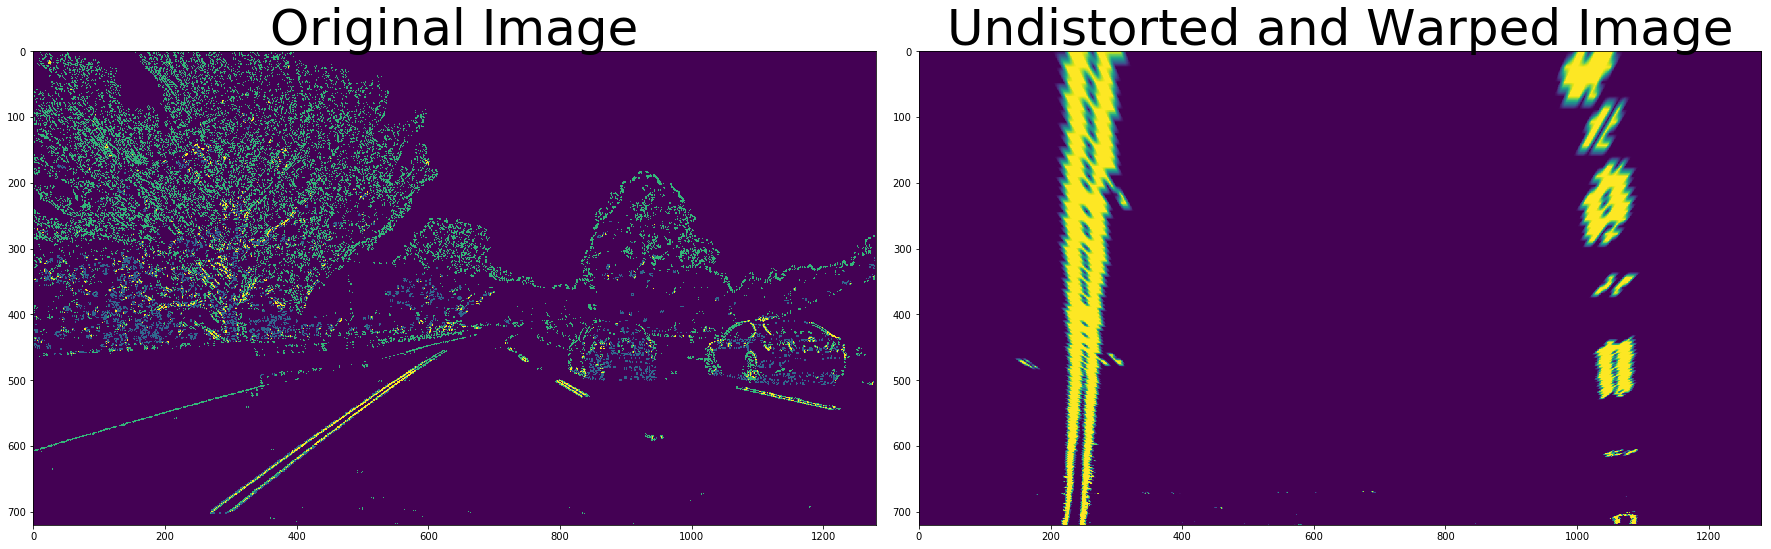

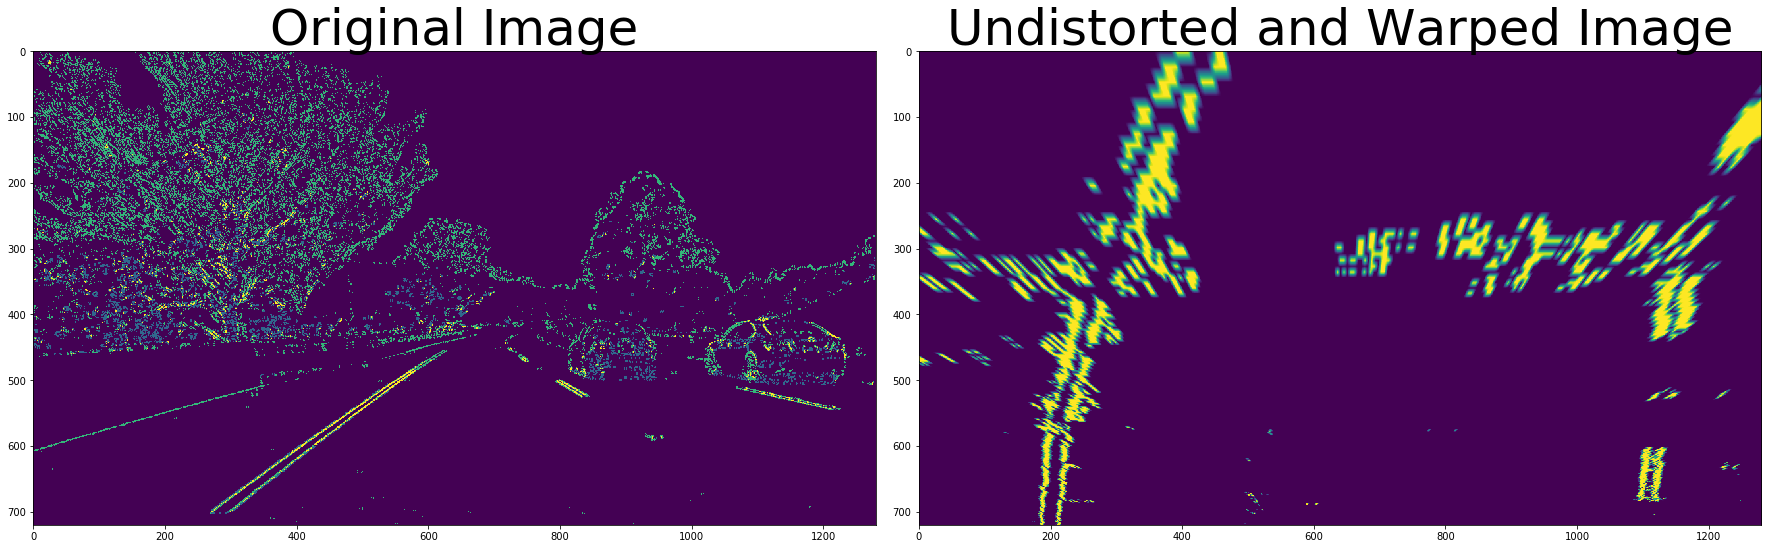

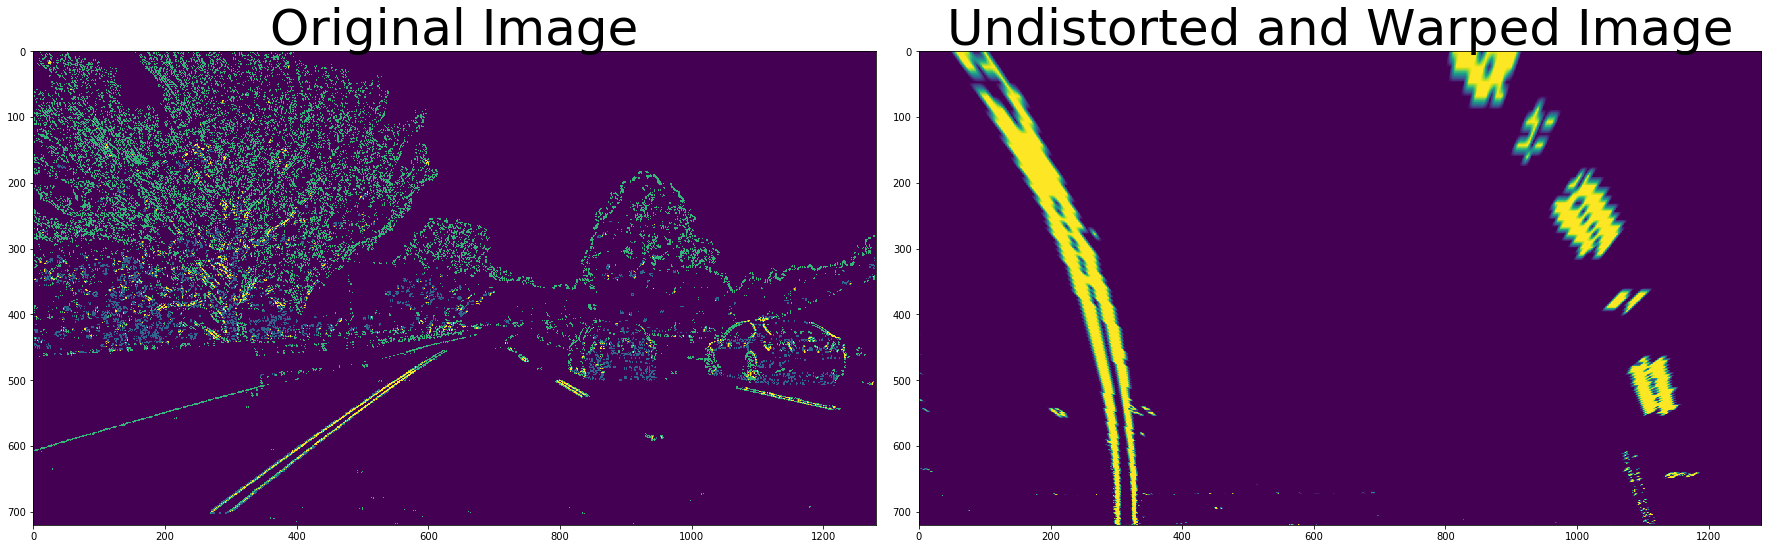

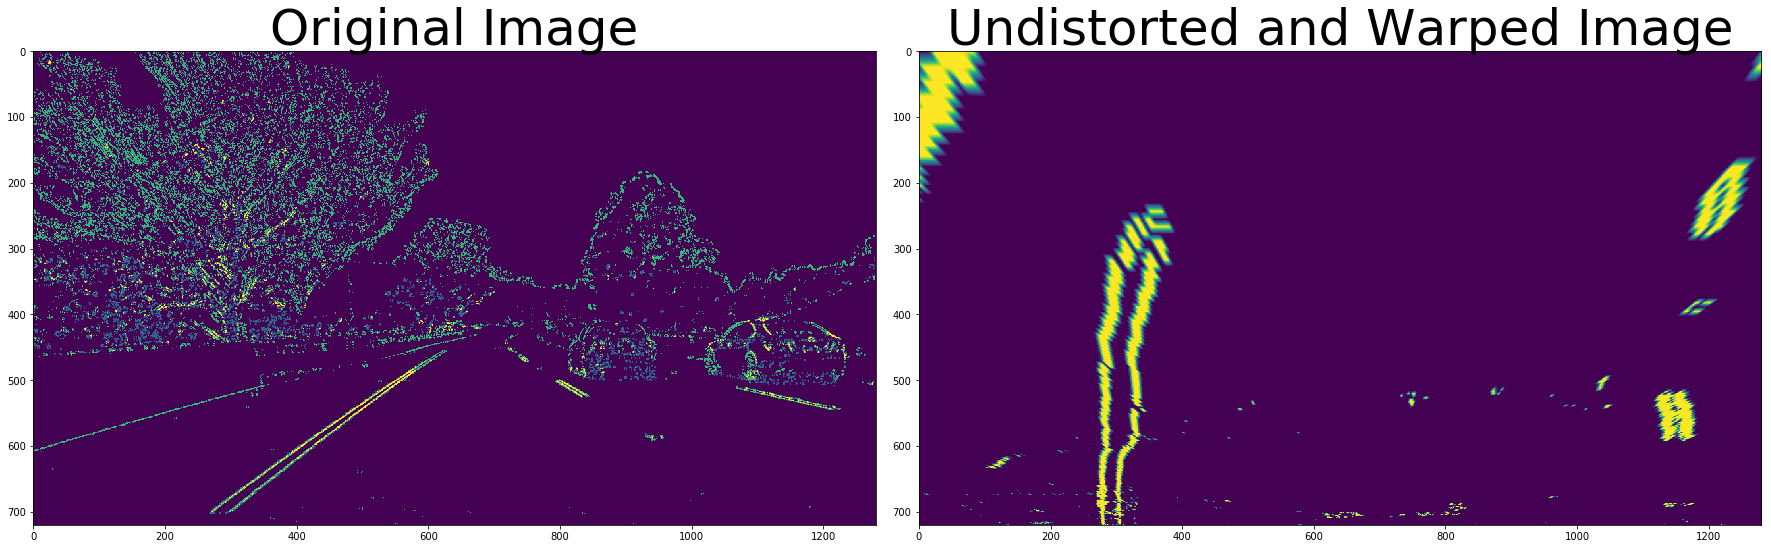

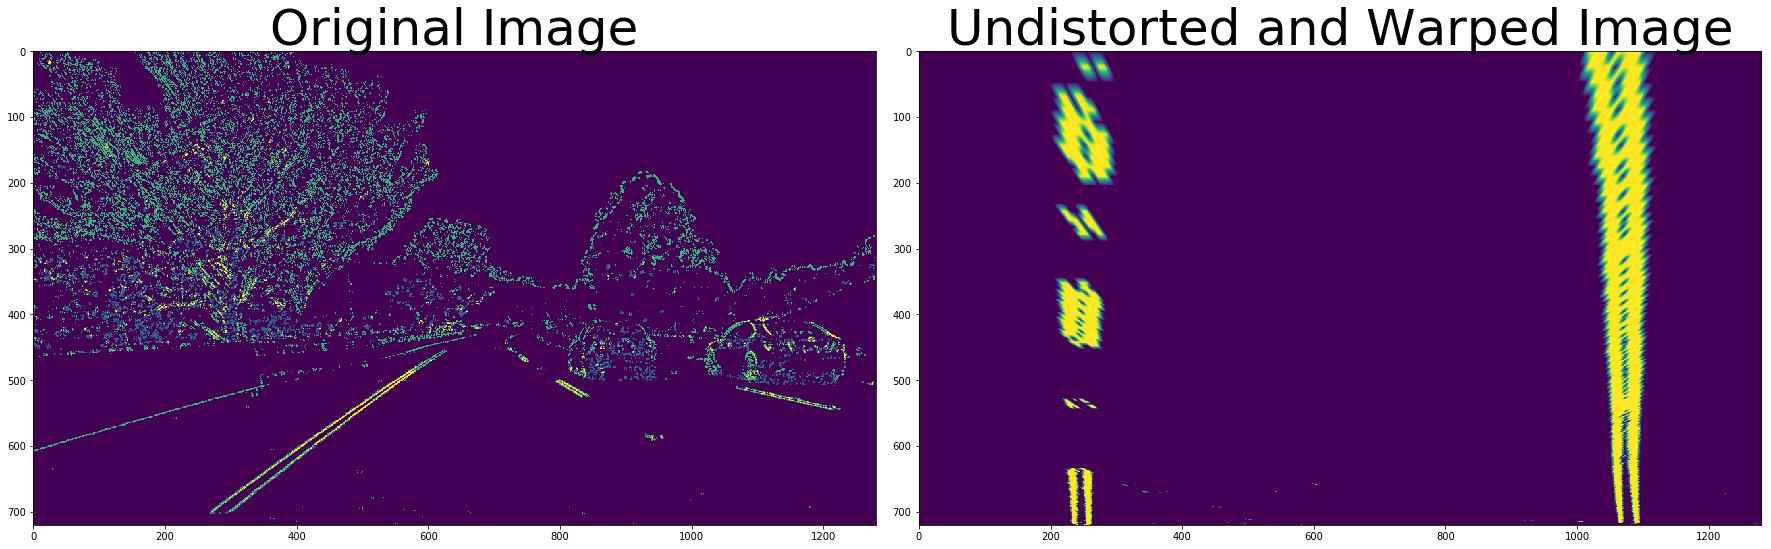

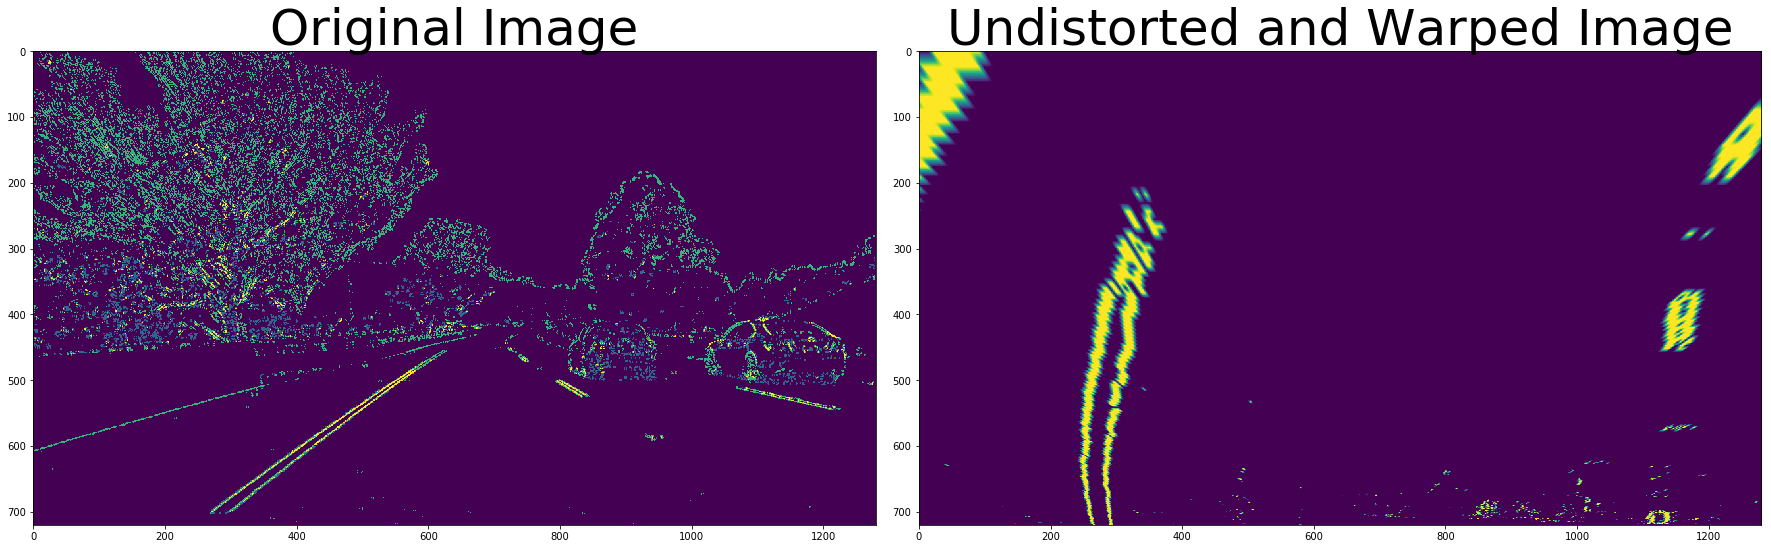

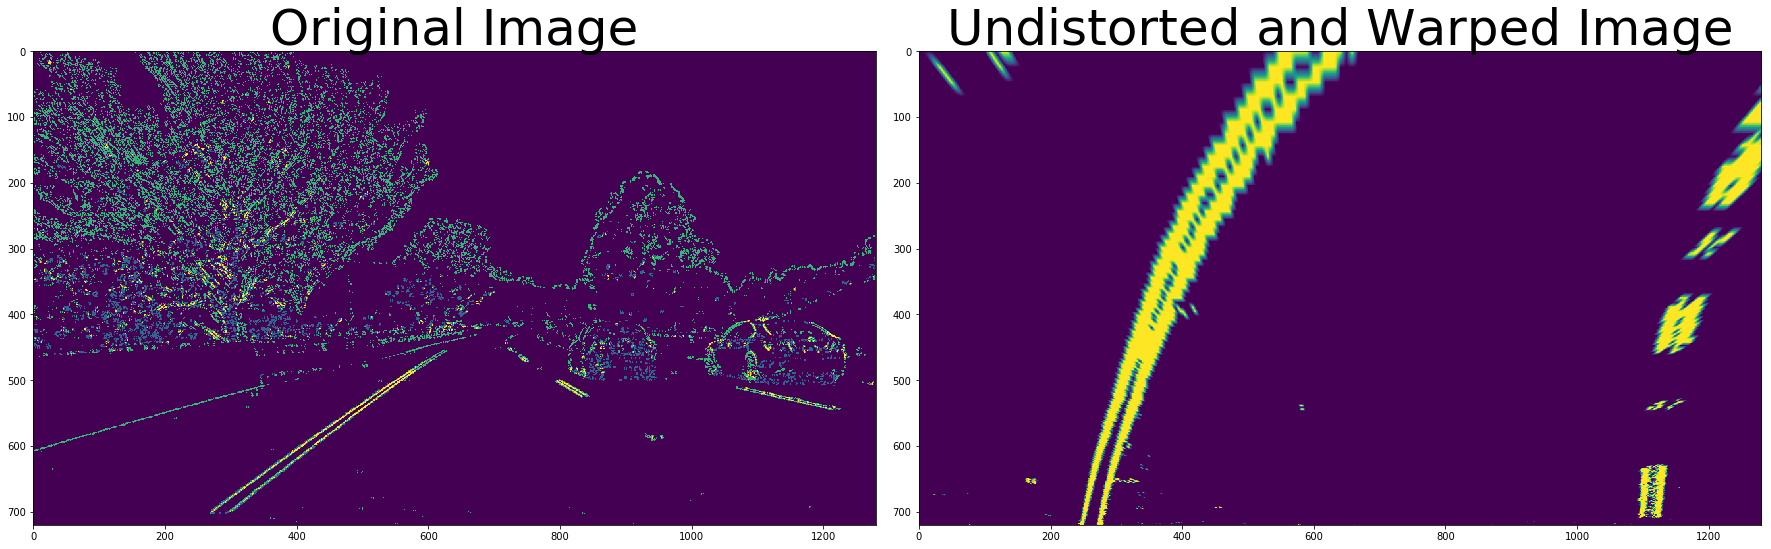

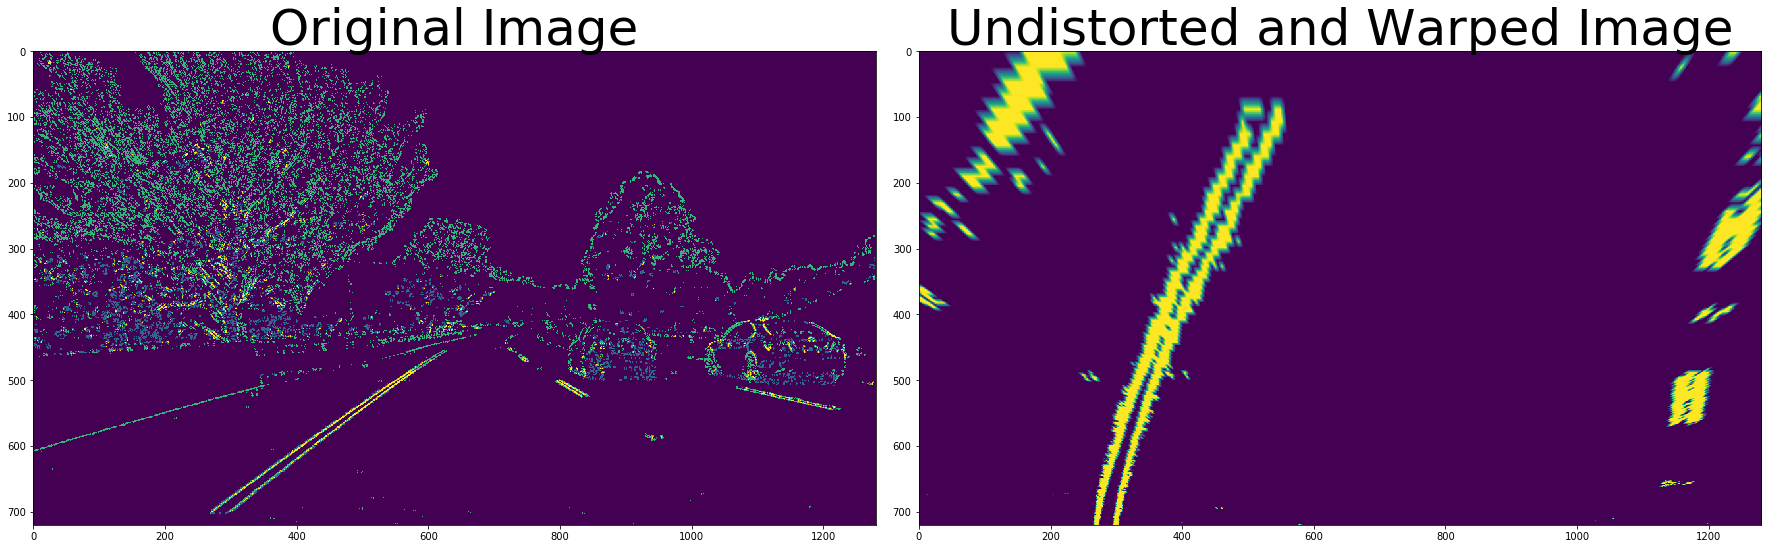

In [72]:
# Testing
# Make a list of calibration images
# Step through the list and search for chessboard corners
for x in os.listdir("test_images/"):
    input_path = "test_images/" + x
    if os.path.isdir(input_path):
        continue
    
    # Read in each raw image
    raw_img = cv2.imread(input_path)
    
    # 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    # 2. Apply a distortion correction to raw images.
    undistorted = cal_undistort(raw_img, objpoints, imgpoints)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    ksize = 15
    x_thresh = (20, 255)
    y_thresh = (20, 255)
    mag_thresh = (30, 255)
    dir_thresh = (0.7, 1.3)
    s_thresh = (150, 255)
    combined_threshed = combined_threshold(undistorted, ksize, x_thresh, y_thresh, mag_thresh, dir_thresh, s_thresh)
    
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    # Appoint source points and destination points
    imshape = (combined_threshed.shape[1], combined_threshed.shape[0])
    # imshape = gray_combined_threshed.shape
    left = 200
    right = 1080
    top = 450
    bot = 700
    
    src_left_top = (0.46*imshape[0], top)
    src_right_top = (0.54*imshape[0], top)
    src_right_bot = (right, bot)
    src_left_bot = (left, bot)
    src = np.float32([[src_left_top, src_right_top, src_right_bot, src_left_bot]])
    dst_left_top = (left, 0)
    dst_right_top = (right, 0)
    dst_right_bot = (right, imshape[1])
    dst_left_bot = (left, imshape[1])
    dst = np.float32([[dst_left_top, dst_right_top, dst_right_bot, dst_left_bot]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(combined_threshed, M, imshape)
    
    # 5. Detect lane pixels and fit to find the lane boundary.
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    # 7. Warp the detected lane boundaries back onto the original image.
    # 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


    # Plotting thresholded imagesf, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(gray_combined_threshed)
    ax1.set_title('Original Image', fontsize=50)
    # ax2.imshow(warped)
    ax2.imshow(warped)
    ax2.set_title('Undistorted and Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    # Select output_image
    output_image = warped
    # print(imshape)
    # print(src)
    # print(dst)
    
    # Show output image
    cv2.imshow('output',output_image)
    cv2.waitKey(100)
    
    # Outout the image to directory "/test_image_output"
    # output_path = "test_image_output/" + x
    # if os.path.isdir(output_path):
    #     continue
    # cv2.imwrite(output_path, output_image)
    
cv2.destroyAllWindows() 

## 5. Detect lane pixels and fit to find the lane boundary.